# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories.

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.


## Import Resources

In [ ]:
%pip install tfds-nightly --user
%pip install --upgrade tensorflow --user

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
# Make all other necessary imports.
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import json

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [ ]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# Create a training set, a validation set and a test set.
training_set, test_set, validation_set= dataset['train'], dataset['test'],dataset['validation']

## Explore the Dataset

In [4]:
# Get the number of examples in each set from the dataset info.
num_training_examples  = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
total_num_examples= num_training_examples+num_test_examples+num_validation_examples

print('There are {:,} images in the test set'.format(num_test_examples))
print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))

# Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('\nThere are {:,} classes in our dataset'.format(num_classes))

There are 6,149 images in the test set
There are 1,020 images in the training set
There are 1,020 images in the validation set

There are 102 classes in our dataset


In [5]:
# Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    image = image.numpy().squeeze()
    label = label.numpy()
    print('The label of the image is:', label)
    print('The shape of the image is:', image.shape)
    print('\n')

The label of the image is: 72
The shape of the image is: (500, 667, 3)


The label of the image is: 84
The shape of the image is: (500, 666, 3)


The label of the image is: 70
The shape of the image is: (670, 500, 3)




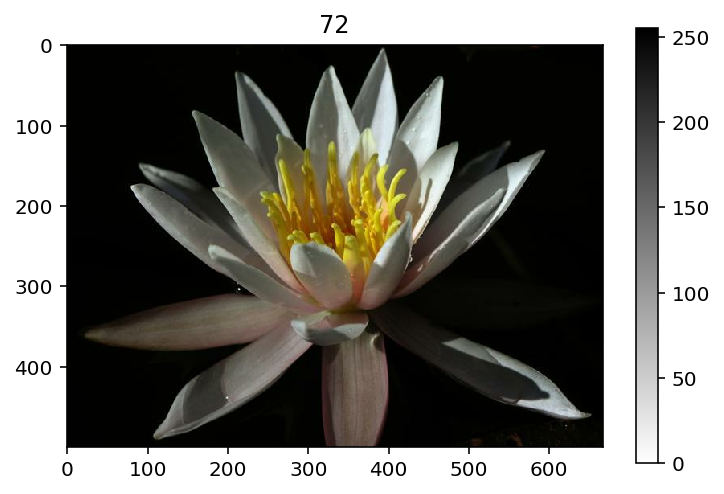

In [6]:
# Plot 1 image from the training set. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.title(label)
plt.show()
# Set the title of the plot to the corresponding image label. 

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

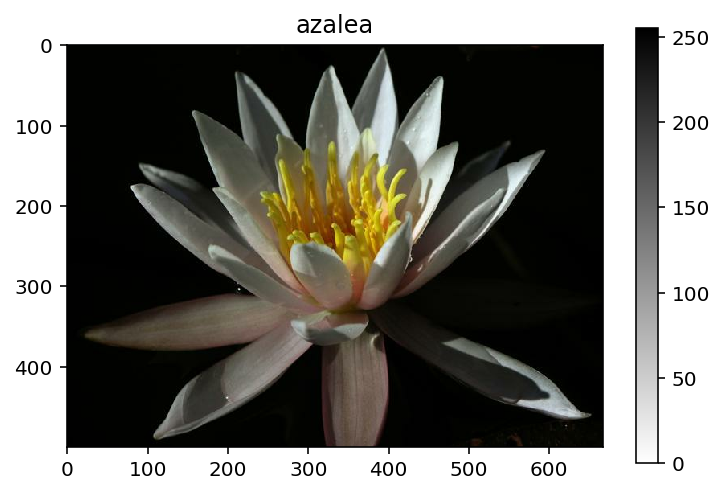

In [8]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    label = str(label) #https://careerkarma.com/blog/python-string-to-int/

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.title(class_names[label])
plt.show()

## Create Pipeline

In [9]:
# Create a pipeline for each set.
batch_size = 32
image_size = 224

train_split=60
test_val_split = 20
num_training_examples = (total_num_examples * train_split) // 100

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.


In [10]:
# Build your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Train your network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
32/32 [==============================] - 51s 1s/step - loss: 4.6939 - accuracy: 0.0524 - val_loss: 3.0974 - val_accuracy: 0.3676
Epoch 2/20
32/32 [==============================] - 46s 1s/step - loss: 2.3256 - accuracy: 0.6173 - val_loss: 2.0287 - val_accuracy: 0.6441
Epoch 3/20
32/32 [==============================] - 46s 1s/step - loss: 1.2181 - accuracy: 0.8899 - val_loss: 1.5485 - val_accuracy: 0.7324
Epoch 4/20
32/32 [==============================] - 46s 1s/step - loss: 0.7215 - accuracy: 0.9569 - val_loss: 1.3031 - val_accuracy: 0.7725
Epoch 5/20
32/32 [==============================] - 45s 1s/step - loss: 0.4651 - accuracy: 0.9825 - val_loss: 1.1656 - val_accuracy: 0.7863
Epoch 6/20
32/32 [==============================] - 45s 1s/step - loss: 0.3122 - accuracy: 0.9963 - val_loss: 1.0805 - val_accuracy: 0.7980
Epoch 7/20
32/32 [==============================] - 46s 1s/step - loss: 0.2616 - accuracy: 0.9969 - val_loss: 1.0143 - val_accuracy: 0.8098
Epoch 8/20
32/32 [==

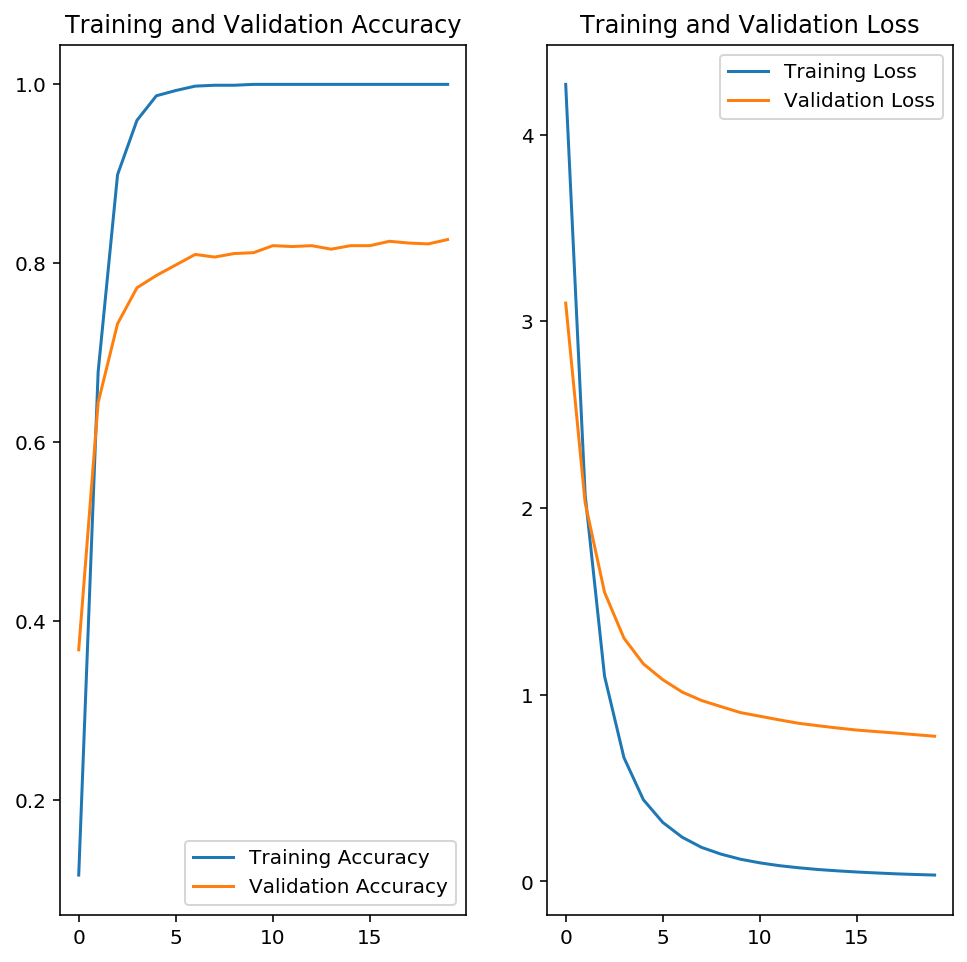

In [12]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Print the loss and accuracy values achieved on the entire test set.
loss, accuracy =model.evaluate(testing_batches)
print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 133s 688ms/step - loss: 0.9047 - accuracy: 0.7754

Loss on the TEST Set: 0.905
Accuracy on the TEST Set: 77.541%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference.

In [14]:
# Save your trained model as a Keras model.
model_name='saved_model'
saved_keras_model_filepath = './{}.h5'.format(model_name)
model.save(saved_keras_model_filepath)

## Load the Keras Model

Load the Keras model you saved above.

In [15]:
# Load the Keras model
saved_model=tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})
#https://stackoverflow.com/questions/61814614/unknown-layer-keraslayer-when-i-try-to-load-model

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities.

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

In [16]:
# Create the process_image function
def process_image(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    image= image.numpy()
    return image

To check your `process_image` function we have 4 images:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

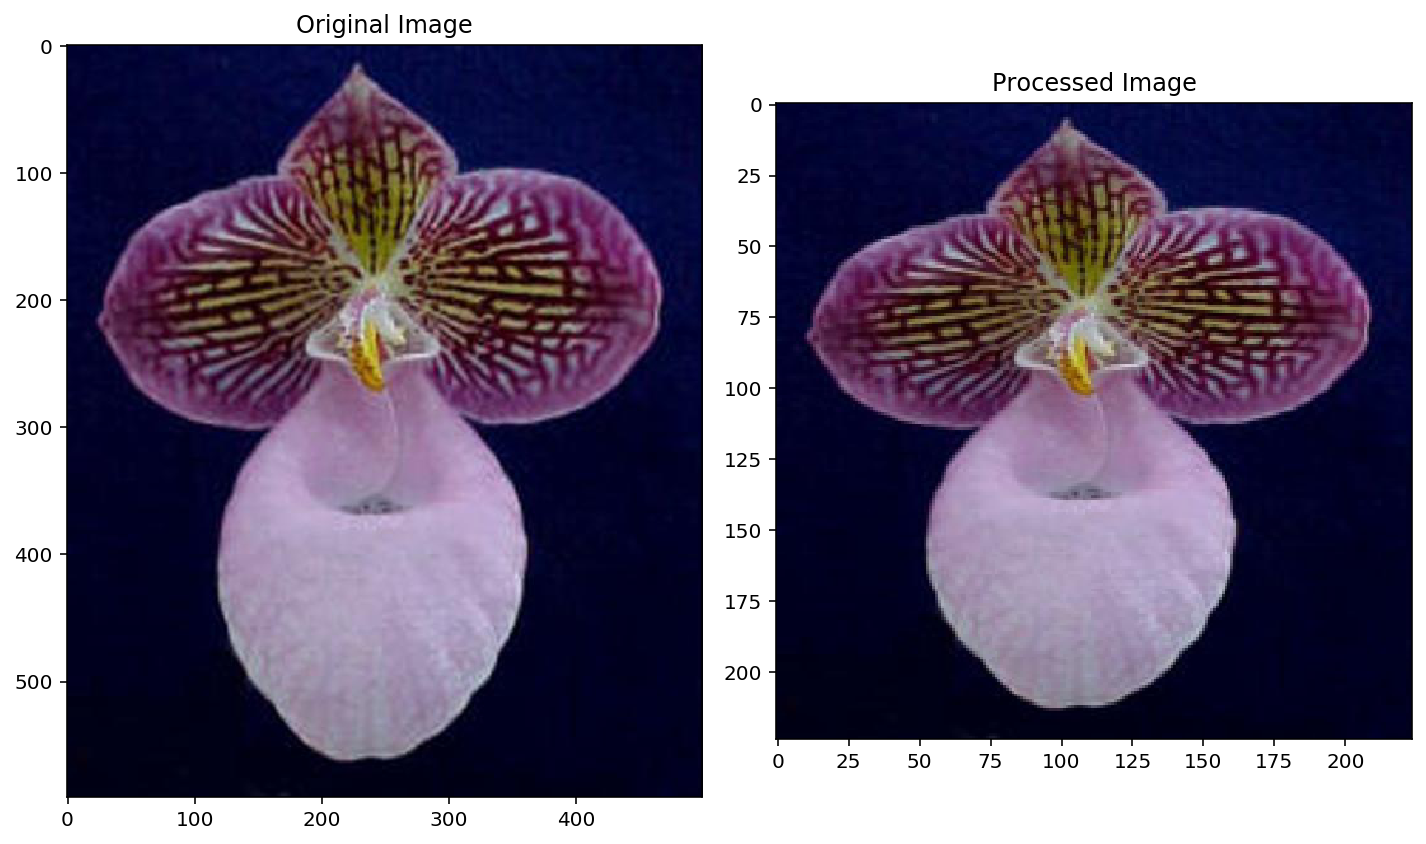

In [17]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()


### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities.

In [18]:
# Create the predict function
def predict(image_path, model, top_k):
    class_names_predicted=[]
    ps = saved_model.predict(image_path)
    ps=np.array(ps[0])
    a= sorted(range(len(ps)), key=lambda i: ps[i])[-top_k:]  #https://stackoverflow.com/questions/13070461/get-indices-of-the-top-n-values-of-a-list
    probs= ps[a]
    for x in a:
        class_names_predicted.append(class_names[str(x)]) # https://www.geeksforgeeks.org/python-ways-to-concatenate-two-lists/
    return probs,class_names_predicted

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have 4 images.

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. 

You can convert from the class integer labels to actual flower names using `class_names`. 

In [19]:
# Plot the input image along with the top 5 classes
first_image = './test_images/cautleya_spicata.jpg'
second_image = './test_images/hard-leaved_pocket_orchid.jpg'
third_image = './test_images/orange_dahlia.jpg'
fourth_image = './test_images/wild_pansy.jpg'

def plot_image1(image):
    im = Image.open(image)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image=np.expand_dims(processed_test_image,axis=0) #https://www.w3resource.com/numpy/manipulation/expand-dims.php
    probs,classes=predict(processed_test_image, saved_model, 5)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(13,15), ncols=2)
    ax1.imshow(test_image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax2.barh(np.arange(5), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

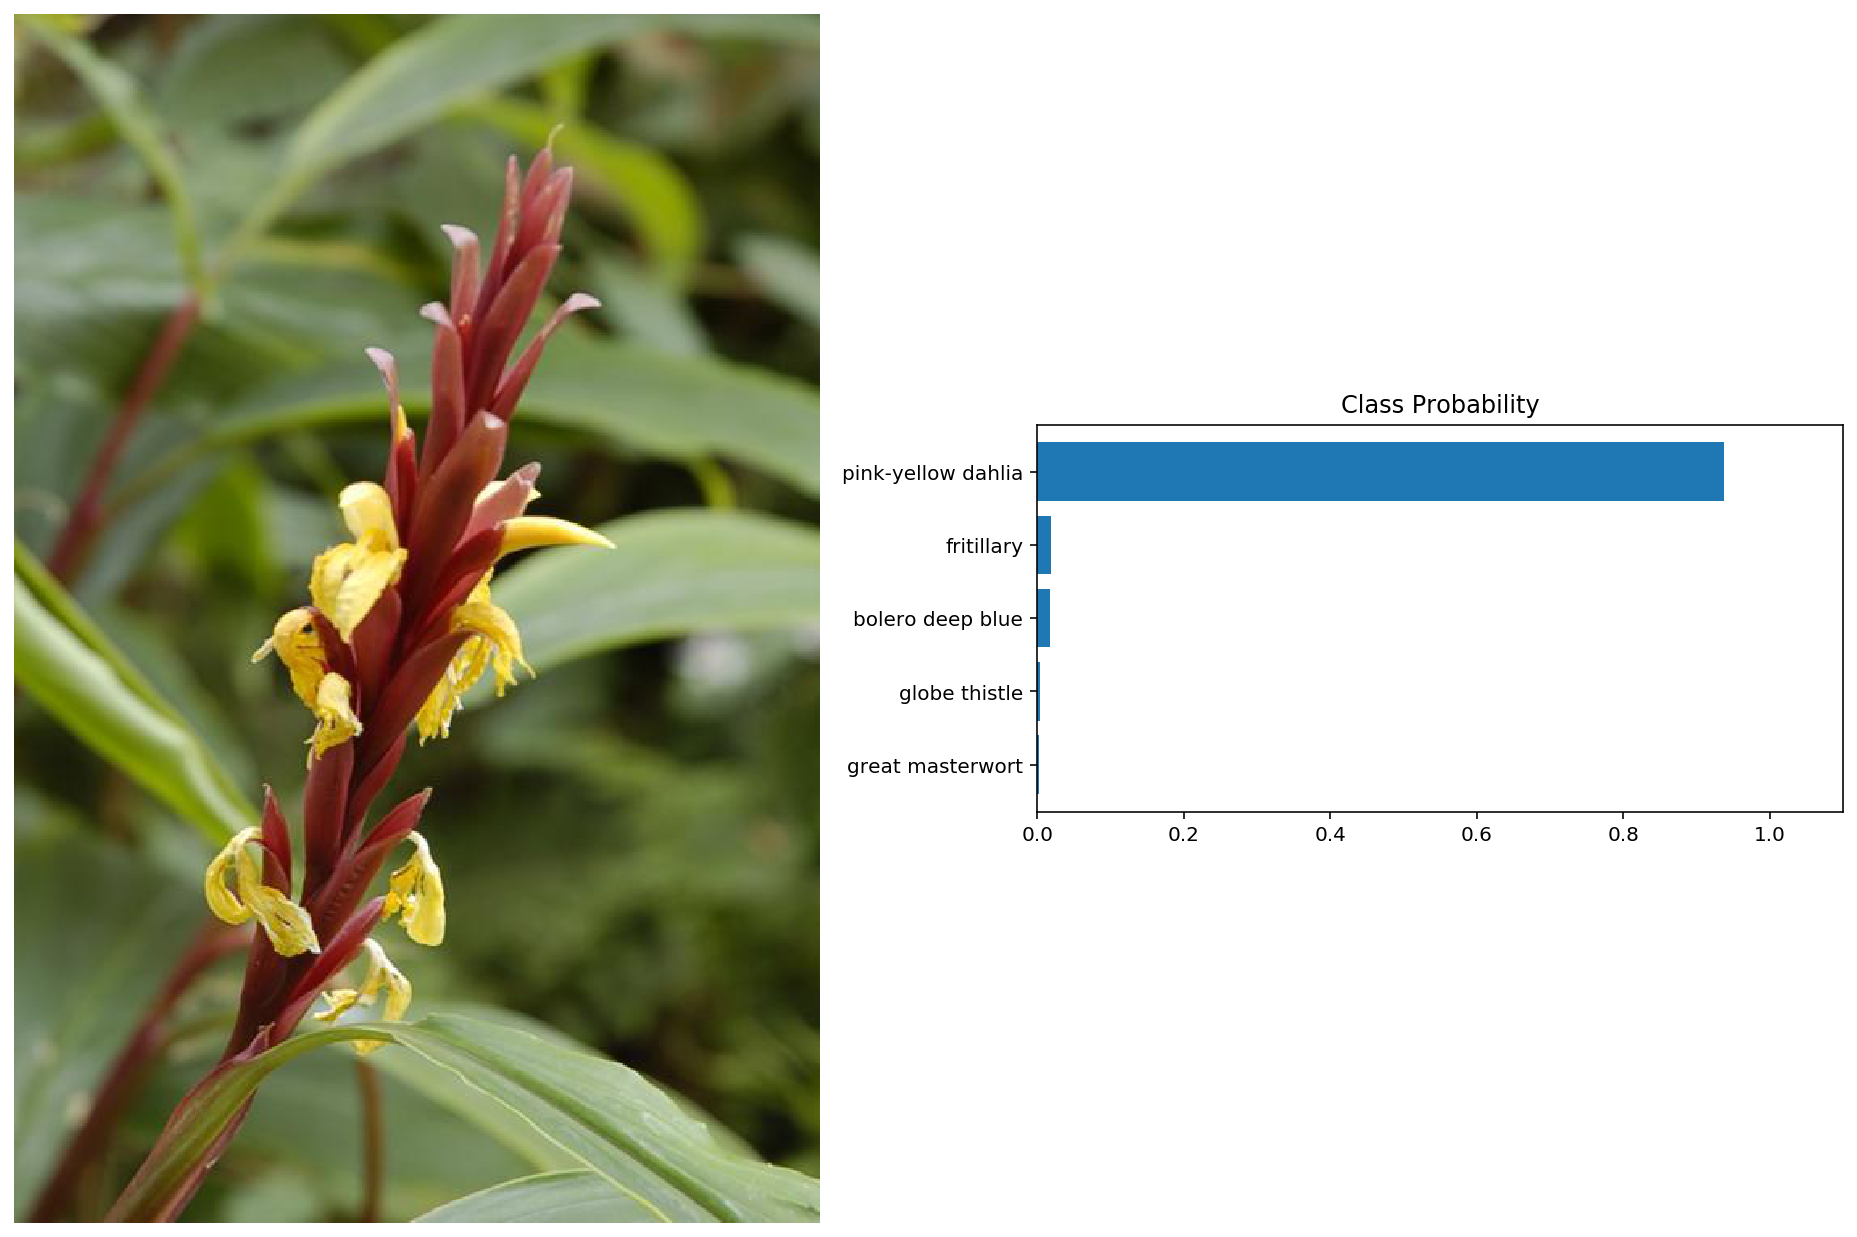

In [20]:
plot_image1(first_image)

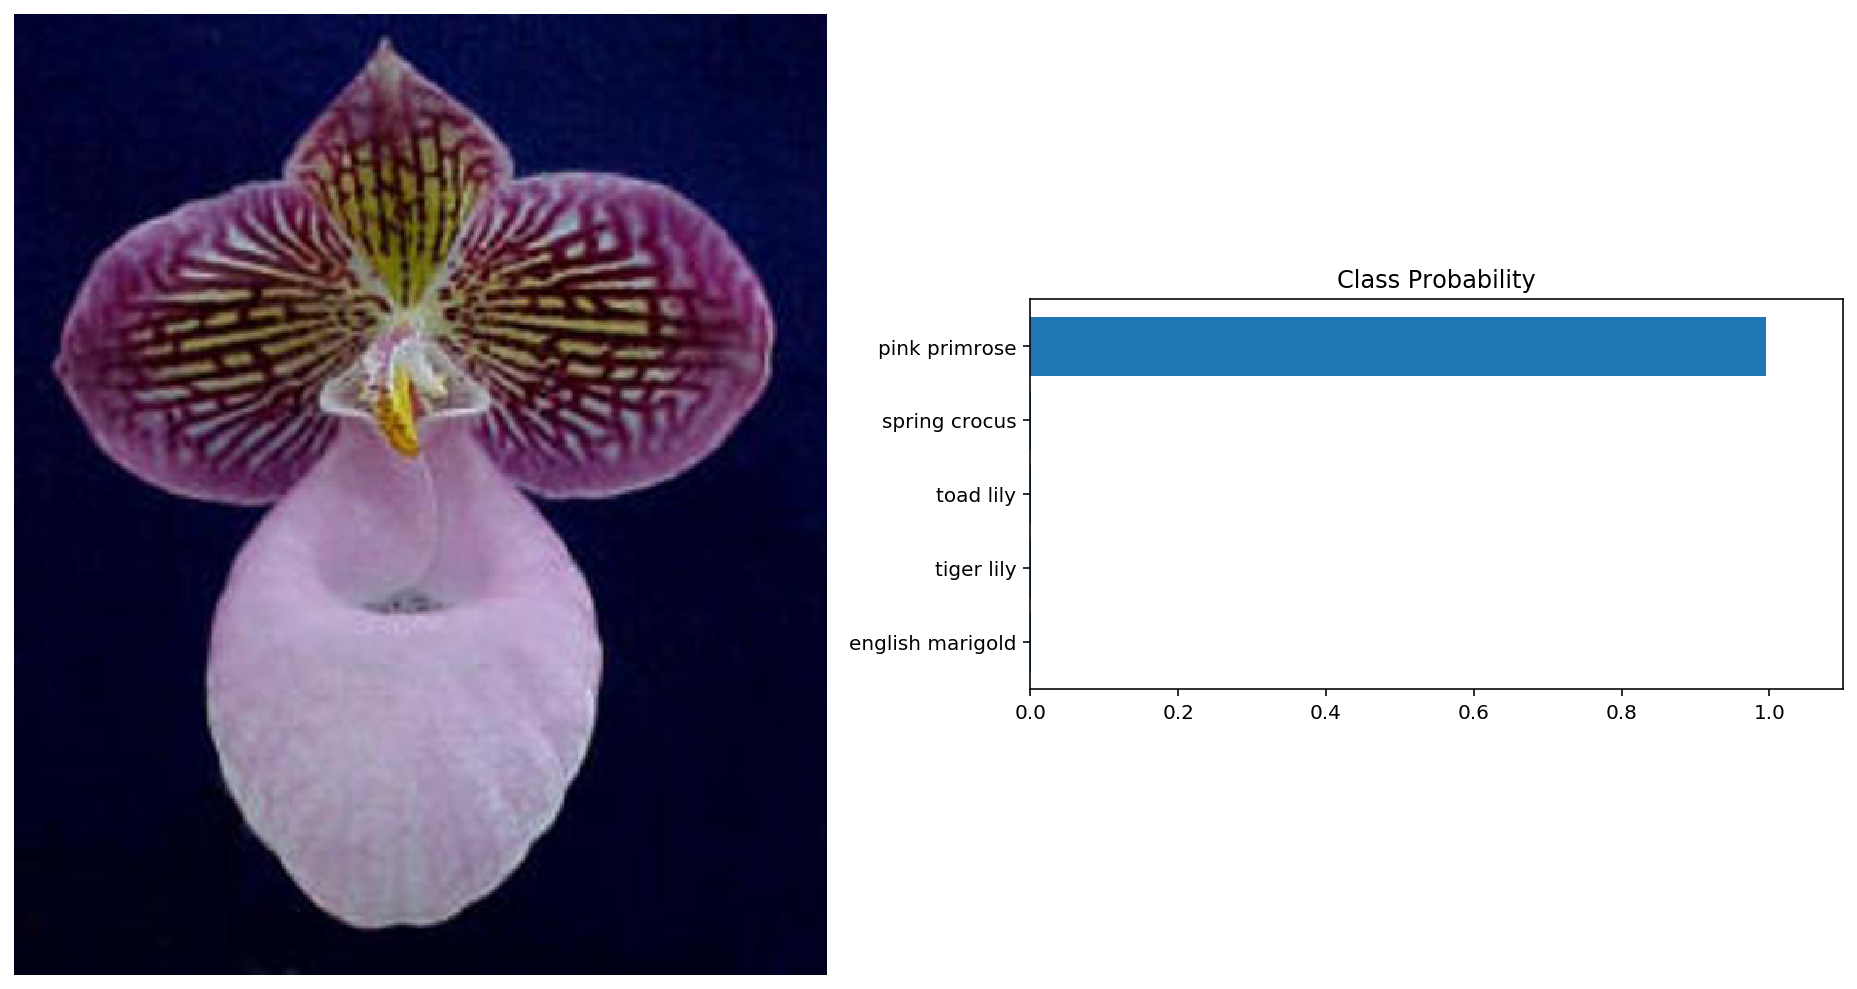

In [21]:
plot_image1(second_image)

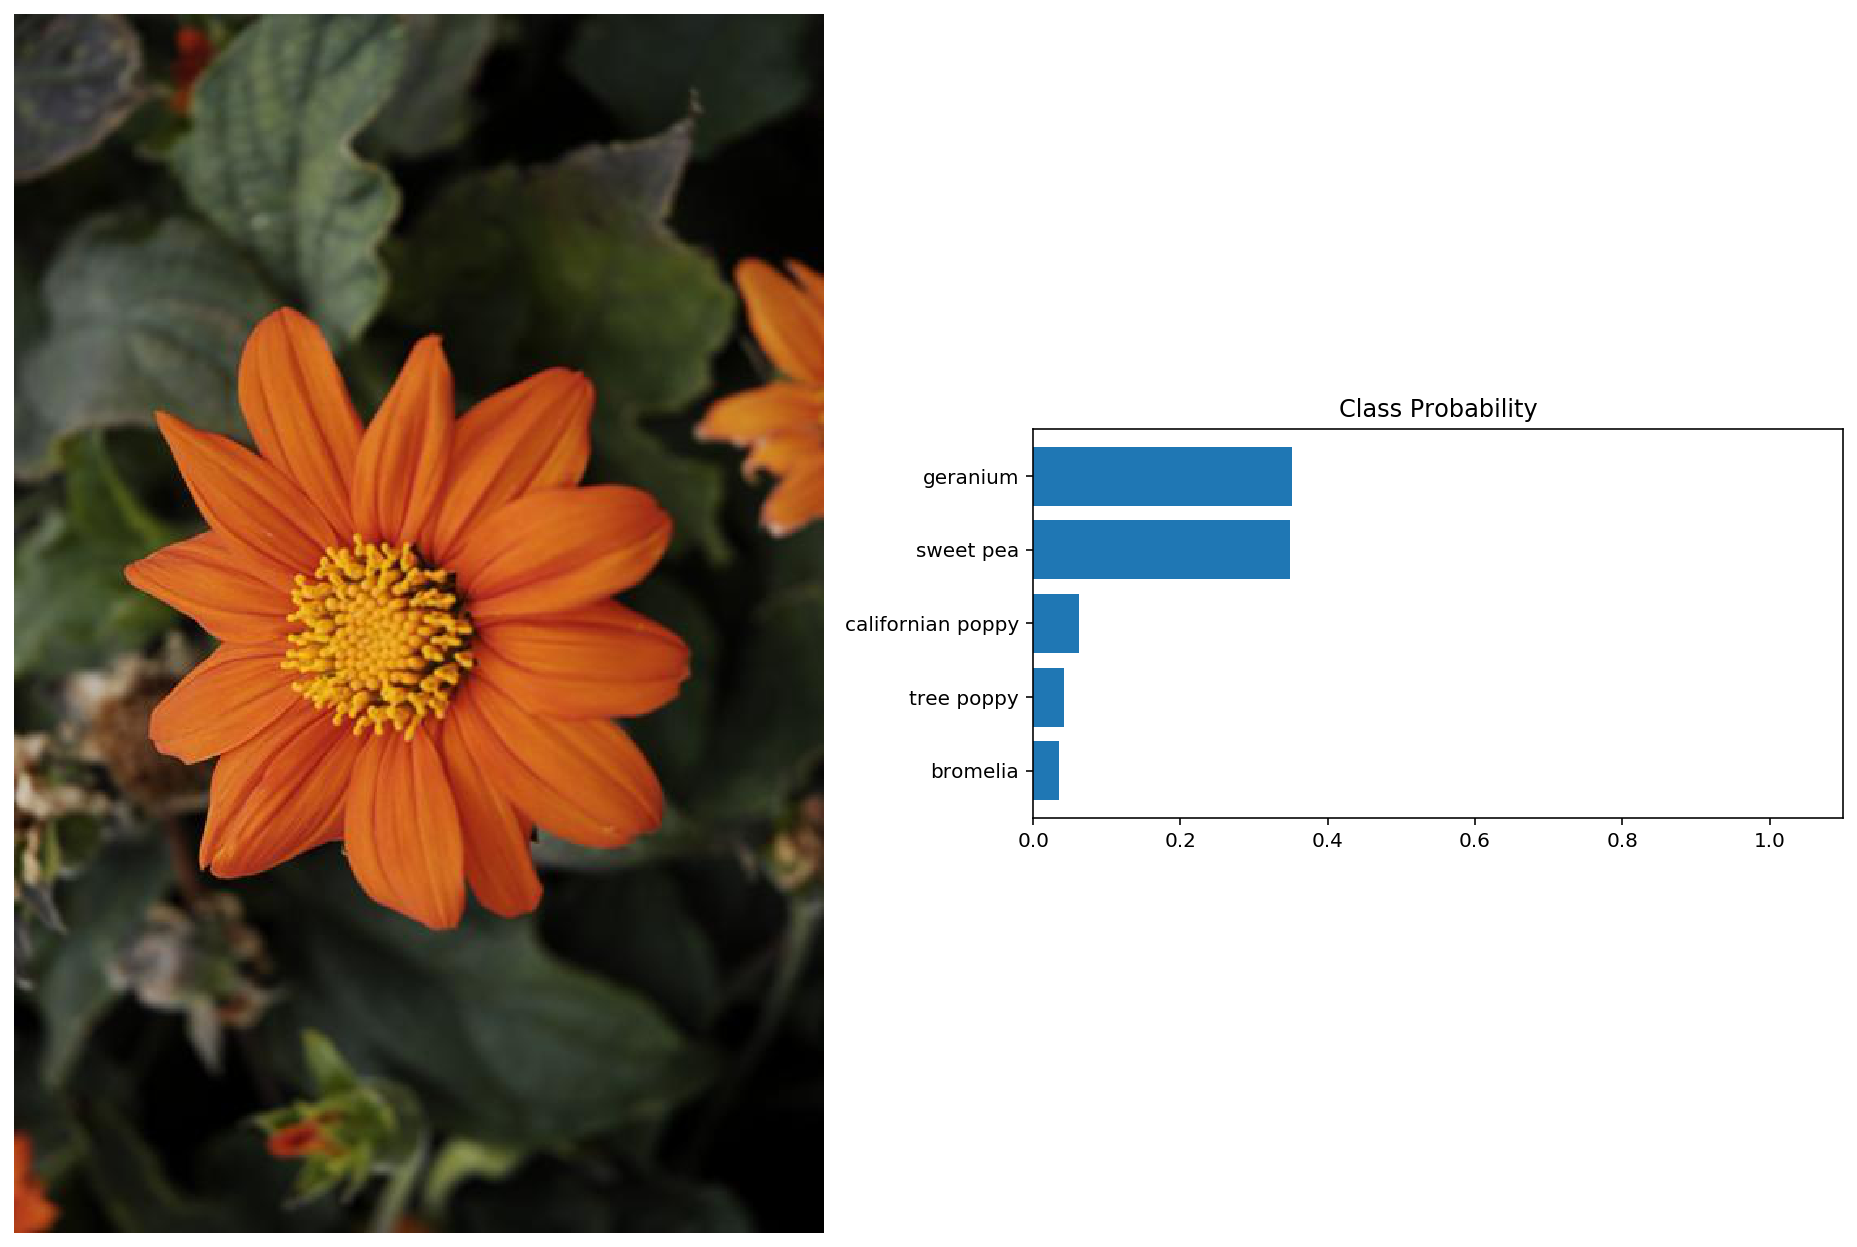

In [22]:
plot_image1(third_image)

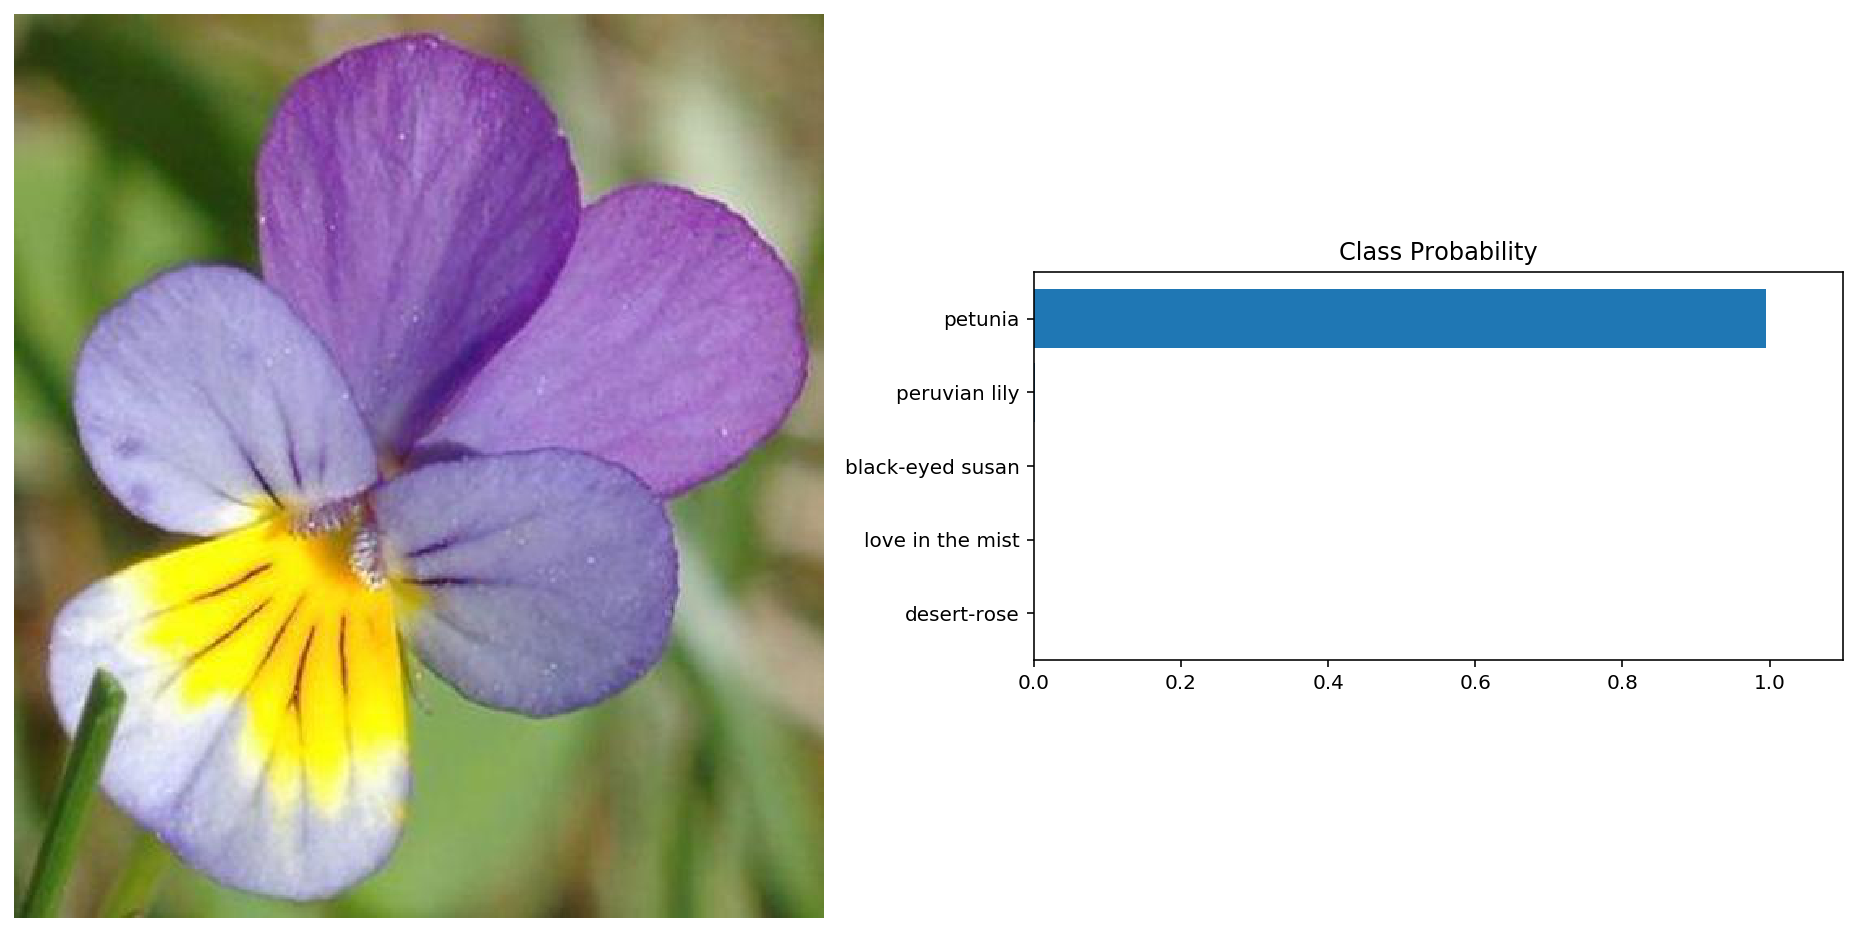

In [23]:
plot_image1(fourth_image)